# Random Forest Simulation

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from matplotlib import pyplot as plt


# Get the ranking Data
rankings = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/fifa_ranking.csv")
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

# Fix some country names
rankings = rankings.replace({"IR Iran": "Iran"})
# Get weighted points by summing cur_year_avg_weighted + two_year_ago_weighted + three_year_ago_weighted
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date']) # change to pandas datetime format

# Get the match Data
matches = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/results.csv")
# Fix some country names
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

# Get the world cup fixture data
world_cup = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/WorldCup2018Dataset.csv")

# extract relavent columns
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]

# Drop NAs
world_cup = world_cup.dropna(how='all')

# Fix some country names
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
# set index to team 
world_cup = world_cup.set_index('Team')

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a team ranking dictionary
def get_team_ranking_data(team, date, ranking_data):
    if date is None:
        team_data = ranking_data.loc[ranking_data['country_full'] == team]
    else:
        team_data = ranking_data.loc[(ranking_data['country_full'] == team) & (ranking_data['rank_date'] <= date)]
    
    if len(team_data) > 0:
        team_data = team_data.loc[team_data['rank_date'].idxmax()]
        return {'rank': team_data['rank'], 'weighted_points': team_data['weighted_points']}
    return None

# Prepare the dataset
def get_match_features(match, ranking_data):
    home_team = get_team_ranking_data(match['home_team'], match.get('date', None), ranking_data)
    away_team = get_team_ranking_data(match['away_team'], match.get('date', None), ranking_data)
    
    if home_team is None or away_team is None:
        return None
    
    features = [home_team['rank'], home_team['weighted_points'],
                away_team['rank'], away_team['weighted_points']]
    return features

In [ ]:
# Create a dictionary to store team rankings
team_rankings = {}

# Get the latest ranking data for each team
for index, row in rankings.iterrows():
    country = row['country_full']
    if country not in team_rankings or team_rankings[country]['rank_date'] < row['rank_date']:
        team_rankings[country] = {
            'rank': row['rank'],
            'weighted_points': row['weighted_points'],
            'rank_date': row['rank_date']
        }

# Modify get_match_features to use team_rankings
def get_match_features(match, ranking_data):
    home_team = team_rankings.get(match['home_team'], None)
    away_team = team_rankings.get(match['away_team'], None)
    
    if home_team is None or away_team is None:
        return None
    
    features = [home_team['rank'], home_team['weighted_points'],
                away_team['rank'], away_team['weighted_points']]
    return features

# Get the features and labels for training
X = []
y = []
for index, match in matches.iterrows():
    if match['home_team'] in rankings['country_full'].values and match['away_team'] in rankings['country_full'].values:
        features = get_match_features(match, rankings)
        if features is not None:
            X.append(features)
            y.append(1 if match['home_score'] > match['away_score'] else 0)

print(f"Number of samples: {len(X)}")


Number of samples: 34261


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Test the classifier
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))



Accuracy: 0.6459944549832191


In [ ]:
# Modify the predict_winner function
def predict_winner(team1, team2, ranking_data, classifier):
    features = get_match_features({'home_team': team1, 'away_team': team2}, ranking_data)
    prediction = classifier.predict([features])
    return team1 if prediction == 1 else team2



In [ ]:
# Predict the group stage winners
world_cup_rankings = rankings.loc[rankings['rank_date'] == rankings['rank_date'].max(), :]
group_winners = []

for group, teams in world_cup.groupby('Group'):
    group_teams = [world_cup_rankings.loc[world_cup_rankings['country_full'] == team, 'country_full'].values[0] for team in teams.index]
    winner = group_teams[0]
    
    for i, team1 in enumerate(group_teams):
        for j, team2 in enumerate(group_teams[i+1:]):
            winner = predict_winner(team1, team2, world_cup_rankings, clf)
    
    group_winners.append(winner)


In [ ]:
# Predict the knockout stage winners
knockout_rounds = ['Round of 16', 'Quarterfinal', 'Semifinal', 'Final']
round_winners = group_winners

for knockout_round in knockout_rounds:
    print(f"{knockout_round} winners:")
    new_round_winners = []
    
    for i, team1 in enumerate(round_winners):
        for j, team2 in enumerate(round_winners[i+1:]):
            winner = predict_winner(team1, team2, world_cup_rankings, clf)
            new_round_winners.append(winner)
            print(f"{team1} vs {team2}: {winner}")
            break
            
    round_winners = new_round_winners


Round of 16 winners:
Uruguay vs Morocco: Morocco
Morocco vs Denmark: Denmark
Denmark vs Croatia: Croatia
Croatia vs Serbia: Croatia
Serbia vs Sweden: Serbia
Sweden vs England: England
England vs Japan: Japan
Quarterfinal winners:
Morocco vs Denmark: Denmark
Denmark vs Croatia: Croatia
Croatia vs Croatia: Croatia
Croatia vs Serbia: Croatia
Serbia vs England: England
England vs Japan: Japan
Semifinal winners:
Denmark vs Croatia: Croatia
Croatia vs Croatia: Croatia
Croatia vs Croatia: Croatia
Croatia vs England: England
England vs Japan: Japan
Final winners:
Croatia vs Croatia: Croatia
Croatia vs Croatia: Croatia
Croatia vs England: England
England vs Japan: Japan


## Implementing Time-Based Split

In [8]:
# Fixing the SSL error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [9]:
# Get the match Data
matches = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/results.csv")

In [10]:
# Fix some country names
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])
matches = matches.sort_values(by='date')

In [11]:
# Option 1: Split based on a specific date
split_date = pd.to_datetime('2014-01-01')
train_matches = matches[matches['date'] < split_date]
test_matches = matches[matches['date'] >= split_date]

In [14]:
X_train, y_train = [], []
for index, match in train_matches.iterrows():
    if match['home_team'] in rankings['country_full'].values and match['away_team'] in rankings['country_full'].values:
        features = get_match_features(match, rankings)
        if features is not None:
            X_train.append(features)
            y_train.append(1 if match['home_score'] > match['away_score'] else 0)

X_test, y_test = [], []
for index, match in test_matches.iterrows():
    if match['home_team'] in rankings['country_full'].values and match['away_team'] in rankings['country_full'].values:
        features = get_match_features(match, rankings)
        if features is not None:
            X_test.append(features)
            y_test.append(1 if match['home_score'] > match['away_score'] else 0)


In [15]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6257467144563919


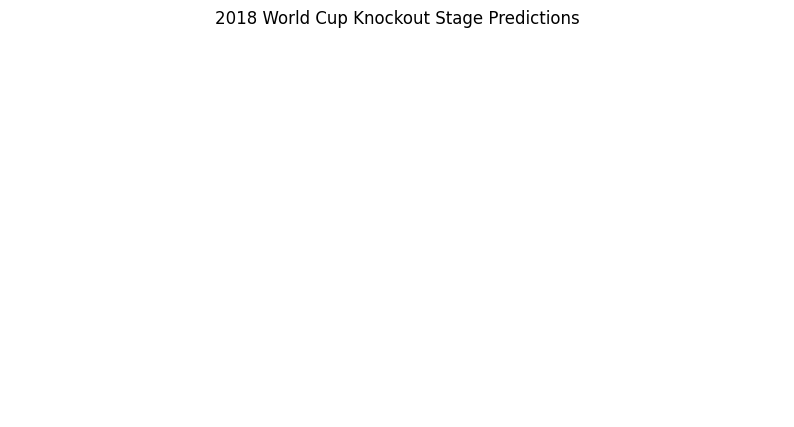

In [16]:
import matplotlib.pyplot as plt

knockout_stages = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

# Predict the knockout stage winners
knockout_results = []

for stage in knockout_stages:
    stage_results = []
    matches = world_cup.loc[world_cup['Group'] == stage]
    for index, match in matches.iterrows():
        team1, team2 = match['Team'], match['First match \nagainst']
        winner = predict_winner(team1, team2, rankings, clf)
        stage_results.append((team1, team2, winner))
    knockout_results.append(stage_results)


def plot_bracket(knockout_results):
    levels = len(knockout_results)
    fig, ax = plt.subplots(figsize=(10, 5))
    
    for level, matches in enumerate(knockout_results, start=1):
        for idx, match in enumerate(matches):
            y1 = (2 ** (levels - level)) * (idx * 2)
            y2 = y1 + (2 ** (levels - level - 1))
            
            ax.annotate(match[0], xy=(level - 1, y1), xycoords='data', ha='right', va='center')
            ax.annotate(match[1], xy=(level - 1, y2), xycoords='data', ha='right', va='center')
            
            winner = match[2]
            if winner == match[0]:
                winner_y = y1
            else:
                winner_y = y2
                
            ax.annotate(winner, xy=(level, winner_y), xycoords='data', ha='left', va='center')
            ax.plot([level - 1, level], [y1, winner_y], 'k-', lw=1.5)
            ax.plot([level - 1, level], [y2, winner_y], 'k-', lw=1.5)
    
    ax.set_ylim(-1, 2 ** levels)
    ax.set_xlim(-1, levels)
    ax.axis('off')
    plt.title("2018 World Cup Knockout Stage Predictions")
    plt.show()

# Call the plot_bracket function with the knockout_results
plot_bracket(knockout_results)
